<a href="https://colab.research.google.com/github/arvindd22/GenAI-Creative-Text-and-Image-Generation/blob/main/fine_tunning_gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing Dependencies and Mounting

In [1]:
!pip install transformers

In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/drive


### Imports

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import random
import json
import time
import datetime
import os

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup

In [5]:
import torch
torch.manual_seed(64)
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [6]:
!pip show torch

Name: torch
Version: 2.5.1+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchvision


### Setting Device

In [9]:
%cd /content/drive/MyDrive/AutoCompose/

/content/drive/MyDrive/AutoCompose


In [10]:
!nvidia-smi

Thu Jan 30 19:38:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data Preparation

### Data Collection

In [12]:
with open("data/joy.json", "r") as f:
  data = json.load(f)
data = [poem for poem in data if len(poem["poem"].split()) < 100]
print(len(data))
data[:5]

32444


[{'poem': 'And he wooed her with caresses,\nWooed her with his smile of sunshine,\nWith his flattering words he wooed her,\nWith his sighing and his singing,\nGentlest whispers in the branches,\nSoftest music, sweetest odors,\nTill he drew her to his bosom,\nFolded in his robes of crimson,\nTill into a star he changed her,\nTrembling still upon his bosom;\nAnd forever in the heavens\nThey are seen together walking,\nBut the fierce Kabibonokka\nHad his dwelling among icebergs,\nIn the everlasting snow-drifts,\nIn the kingdom of Wabasso,\nIn the land of the White Rabbit.',
  'id': 30},
 {'poem': 'Once, as he was gazing northward,\nFar away upon a prairie\nHe beheld a maiden standing,\nSaw a tall and slender maiden\nAll alone upon a prairie;\nBrightest green were all her garments,\nAnd her hair was like the sunshine.',
  'id': 43},
 {'poem': "Till one morning, looking northward,\nHe beheld her yellow tresses\nChanged and covered o'er with whiteness,\nCovered as with whitest snow-flakes.",

### Data Model

In [13]:
class PoemDataset(Dataset):
  def __init__(self, poems, tokenizer, max_length=768, gpt2_type="gpt2"):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for poem in poems:

      encodings_dict = tokenizer("<|startoftext|>"+poem["poem"]+"<|endoftext|>",
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict["input_ids"]))
      self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [18]:
# Loading GPT2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2',
                                          bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>',
                                          pad_token='<|pad|>')

### Rough

In [19]:
print(tokenizer.encode("<|startoftext|> Hello World <|endoftext|>", padding="max_length", max_length=10))
print(len(tokenizer))

[50257, 18435, 2159, 220, 50256, 50258, 50258, 50258, 50258, 50258]
50259


In [20]:
# Finding length of maximum token in dataset
max_length = max([len(tokenizer.encode(poem["poem"])) for poem in data])
print(max_length)
max_length = 100

345


In [21]:
x = [len(tokenizer.encode(poem["poem"])) for poem in data if len(tokenizer.encode(poem["poem"])) < 100]

In [22]:
y = [len(tokenizer.encode(poem["poem"])) - len(poem["poem"].split()) for poem in data]

In [23]:
print(sum(y)/len(y))

22.750493157440513


99 26907


<function matplotlib.pyplot.show(close=None, block=None)>

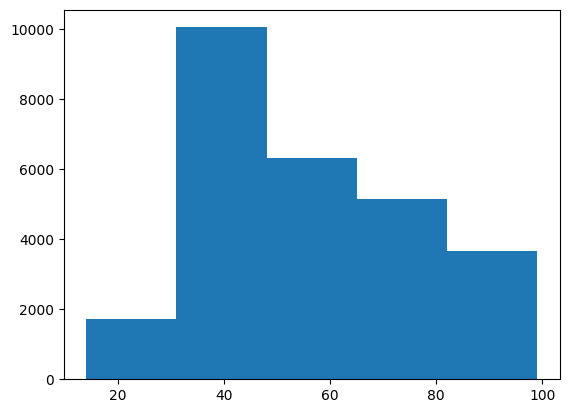

In [24]:
print(max(x), len(x))
plt.hist(x, bins = 5)
plt.show

### Dataset Creation

In [25]:
batch_size = 8
max_length = 100

In [26]:
dataset = PoemDataset(data, tokenizer, max_length=max_length)

# Split data into train and validation sets
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print("Number of samples for training =", train_size)
print("Number of samples for validation =", val_size)

Number of samples for training = 29199
Number of samples for validation = 3245


In [ ]:
train_dataset[0]

(tensor([50257,  5122, 14919,    11,   262,  5156,   326,   537,  2150,   284,
         11906, 10329,    11,   198,  1870,   778, 43535,  1088, 17903,   287,
         11212,   500,   308,  7197,    11,   198, 19242,  7334,   510,    11,
           673,   338,  6405,   290,   734, 24924,  3383,  6510,   198, 11980,
         33091,   287,   607, 37284,   296,   257, 29420,   286,  8716,    82,
            13, 50256, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)

val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size)

# Finetune GPT2 Language Model

### Importing Pre-Trained GPT2 Model

In [ ]:
# Load model configuration
config = GPT2Config.from_pretrained("gpt2")

# Create model instance and set embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)
model.resize_token_embeddings(len(tokenizer))

# Running the model on GPU
model = model.to(device)

In [ ]:
# <<< Optional >>>
# Setting seeds to enable reproducible runs
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

### Scheduling Optimizer

In [ ]:
epochs = 4
warmup_steps = 1e2
sample_every = 100

In [ ]:
print(len(train_dataloader))
print(len(train_dataset))

3650
29199


In [ ]:
# Using AdamW optimizer with default parameters
optimizer = AdamW(model.parameters(), lr=5e-4, eps=1e-8)

# Toatl training steps is the number of data points times the number of epochs
total_training_steps = len(train_dataloader)*epochs

# Setting a variable learning rate using scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_training_steps)

### Training

In [ ]:
def format_time(elapsed):
  return str(datetime.timedelta(seconds=int(round(elapsed))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(epochs):
  print(f'Beginning epoch {epoch_i+1} of {epochs}')

  t0 = time.time()
  total_train_loss = 0
  model.train()

  # Labels are shifted by 1 timestep
  for step, batch in enumerate(train_dataloader):
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    labels=b_labels,
                    attention_mask=b_masks)

    loss = outputs[0]

    batch_loss = loss.item()
    total_train_loss += batch_loss

    # Sampling every x steps
    if step != 0 and step % sample_every == 0:

      elapsed = format_time(time.time()-t0)
      print(f'Batch {step} of {len(train_dataloader)}. Loss: {batch_loss}. Time: {elapsed}')

      model.eval()

      sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
      for i, sample_output in enumerate(sample_outputs):
        print(f'Example ouput: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
      print()

      model.train()

    loss.backward()
    optimizer.step()
    scheduler.step()

  avg_train_loss = total_train_loss / len(train_dataloader)
  training_time = format_time(time.time()-t0)
  print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
  print()

  t0 = time.time()
  model.eval()

  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)

    with torch.no_grad():

        outputs  = model(b_input_ids,
                         attention_mask = b_masks,
                         labels=b_labels)

        loss = outputs[0]

    batch_loss = loss.item()
    total_eval_loss += batch_loss

  avg_val_loss = total_eval_loss / len(val_dataloader)
  val_time = format_time(time.time() - t0)
  print(f'Validation loss: {avg_val_loss}. Validation Time: {val_time}')
  print()

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
          'Training Time': training_time,
          'Validation Time': val_time
      }
  )
  print("------------------------------")

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 3650. Loss: 3.752716064453125. Time: 0:00:35
Example ouput:  bipartisanFor the soul and the rest that love to-day,
There's no more love,
When love is the world's love,
Where love is the world's love--
Where love is the world's love.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 3650. Loss: 3.003690242767334. Time: 0:01:11
Example ouput:  increasingFrom the far shore o'er the shore
Hark up to heaven!
Hark up to heaven!
Hark to heaven!
Hark in Heaven for all my life,
To all my love,
To all my love to be merry.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 3650. Loss: 3.2826004028320312. Time: 0:01:47
Example ouput: day"If in a little place the sun is a-blest!
If it be that you have found it is for you,--
The world is like a world--the world is like a world
And it has not been changed!
And now it's a heaven of grace,
A world of flowers and love that stirs;
But now it is the world that's blest.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 3650. Loss: 2.8988585472106934. Time: 0:02:23
Example ouput:  HangFor, in an hour of love
That comes and goes the joy
As now, I'm gone;
Yet, I'm gone
With joy for a day.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 3650. Loss: 2.140305995941162. Time: 0:02:59
Example ouput:  foodsWhat have thou done with me,
And what shall I give with you?
For, while I, I know not
I know not
A boy with a baby.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 3650. Loss: 2.7889275550842285. Time: 0:03:35
Example ouput:  trailI could speak of thee and love and love and fear,
When young and old, or young and old, and old and old and old,
But my soul could say to you and love and fears to be,
When you were young and old and old and old and old and old and old and old and old and old.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 3650. Loss: 2.9143824577331543. Time: 0:04:11
Example ouput: intendWhat is good now to life?
The life-sleepless nature
That never will seem so;
Yet that which so softly comes!
Life is a troubled earth,
And still the world-wide earth is sad,
Whose voice is not soft;
And yet--oh, to this, the softest,
The greatest, sweetest!
The joy of man or woman
Was never yet like love's heart.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 3650. Loss: 2.6473612785339355. Time: 0:04:47
Example ouput:  surroundI shall be very pleased now to have that
You have not your pains, not your pains, that may be,
But you shall live by your pains.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 3650. Loss: 2.227612018585205. Time: 0:05:23
Example ouput:  reflexThe young heart of a young,
In beauty still seems to move.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 3650. Loss: 2.2460947036743164. Time: 0:05:59
Example ouput:  displayThe sweet maid is there at this touch,
That the maiden never can pass,
And that her softness will be desired;
But my love must never come home
In the same old, old way.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 3650. Loss: 2.8521947860717773. Time: 0:06:35
Example ouput:  pastor_In a world of the dark and sunny days
He's a coward to laugh at his little love,
Than this he shall be of the best.'
Then came one to the door of her door,
And her was at the window,
And on the windows of the door-bight.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 3650. Loss: 2.515275239944458. Time: 0:07:12
Example ouput:  illicitThe lads o' a berry
Of all the lads o' all the lasses;
But oh!  I know they'll go on
To see the lasses o' their birth.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 3650. Loss: 2.245698928833008. Time: 0:07:48
Example ouput:  LiberationI shall know the true star's splendour,
And all the glory of his radiant sight;
But the star's brightest gem is still a star,
And a little light falls from a window to an unseen star;
I love the blossom of the star,
And a sun in its blue heaven of love is shining,
And a garden's soft light and dim with the blue moon's smile;
And a star that blushes in the evening's dawn
In all the splendour of the blue twilight's rays,
To a star, and a star--at night.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 3650. Loss: 2.570171594619751. Time: 0:08:25
Example ouput:  Nam"Oh, it is you, my love,
And I love you now;
For then to say, you shall have the same
That I have never seen.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 3650. Loss: 3.235653877258301. Time: 0:09:01
Example ouput: IONHow should you hear the love you made in your eyes,
And how, after you, have made her sweet moan;
How do you think I will look at you as I do,
And make myself so glad?
What have I of her love? What, and why?
I cannot tell you why,
Or she, I will be glad?
You say she loved you,--oh, you have loved me,--and now you love me.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 3650. Loss: 1.788403034210205. Time: 0:09:37
Example ouput:  glimpseBut then I think I heard to-night,
And the morning breeze from the grass,
And the night comes back to life,
Flaming over my soul in a dream.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 3650. Loss: 2.551776885986328. Time: 0:10:13
Example ouput:  LaureAnd all love the fairest beauty could conceiv,
And all the joyous heart's first love's first love's own sweet joy.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 3650. Loss: 2.720710277557373. Time: 0:10:49
Example ouput: ismIt was a strange sort of passion, which was in all
where that this was not more kind of music, more kind of pain,
than the music of the heart."
The music, which made it seem to be near me, has a power
emphodel in its core, is only as a beautiful
emphodel in its core, and there is a feeling of peace and the
love of the heart; and yet it is
thine own
thoughts that I have known thee, in the pureness of the face,
thoughts that have given
me its tenderness to the face.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 3650. Loss: 3.010333776473999. Time: 0:11:26
Example ouput: ounFor, forsooth in me,
Wher evere I yow,
To speke of him that mai noght
With hirete forto chiere,
That natheles he so schal seith
That he wolde be noght
Er what be mai be envenience
Aein to ben soothes,
And thogh I schal be sovere
That he be of such a wise
That he is so as I swete
The mai be wher herte to lete softe
A-wel ofte lis wyht.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 3650. Loss: 2.676755905151367. Time: 0:12:04
Example ouput:  electionIf you shall not kiss your lips, do I love
Your soft, delicate lips--
I will love you now, you know!
You'd not let the love I would give--
Love me, love me, you more."
Yes, she said--"Oh, love me! I'm sure!
I'm sure as if love I'd give you a kiss,
Would my soul to you be.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 3650. Loss: 3.101613998413086. Time: 0:12:40
Example ouput:  crazyThen I, too, to the fair
Ere he had come from his native shore
From that beautiful land of my childhood.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2200 of 3650. Loss: 2.4288506507873535. Time: 0:13:16
Example ouput:  benchTo hear, so goodly,
In some small garden,
The love that so much sings
To cheer me when I do.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2300 of 3650. Loss: 2.799207925796509. Time: 0:13:52
Example ouput:  incorporatedHis daughter, the widow's daughter,
In their early youth's joyous days didst she wed,
And her wife that joyous life had made
The love that the years had known!
No man she had but looked down,
He sought to make her think,
And he had found her, and he was dead.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2400 of 3650. Loss: 2.3113648891448975. Time: 0:14:29
Example ouput: Peter_Carolled._  It was the day of the day
My heart was glad with joy, and I was glad for her
And my heart was gay with pleasure. And the blue dawn
Shed forth its little star in the night;
And the evening-long day went by.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2500 of 3650. Loss: 2.671018123626709. Time: 0:15:05
Example ouput: uring"I have been a knight of the Lord," they said,
"And this was in my heart a splendid story
Of triumph, and the victory.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2600 of 3650. Loss: 2.5745880603790283. Time: 0:15:41
Example ouput:  reproductiveSo to me, as when it is done,
It is an allurement to her,
With many an eye and many a heart,
That all things are smiling.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2700 of 3650. Loss: 2.888519048690796. Time: 0:16:17
Example ouput:  zoneAway, away, away! away,
And we may not have more leisure here,
We may not enjoy the sun more freely;
The flowers which grow the more, we are never glad.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2800 of 3650. Loss: 2.2377490997314453. Time: 0:16:53
Example ouput:  commitsThe birds of the earth were fain,
The wild-flowers on the green;
The birds of their beauty lived
In silent hues, no more.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2900 of 3650. Loss: 2.129464864730835. Time: 0:17:29
Example ouput:  ironyThe heart-torn birds are wakened in May;
In all their woodland fields in May,
So glad and glad are the trees.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3000 of 3650. Loss: 2.2607898712158203. Time: 0:18:05
Example ouput:  SahThan a fair maid the children meet
Thy happy hours, with a smile so sweet
And so sweet, is a merry, happy night;
A happy night is sweet and fair
By her side! and a happy dream
When all is day;
Fair night's sweet morning is by
When Spring is near,
And the summer day is bright.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3100 of 3650. Loss: 2.3492698669433594. Time: 0:18:42
Example ouput:  BryanThere were flowers and flower and sunshine in the spring:
In the light that bloom'd the summer night;
In the sunshine 'neath the starry sky;
In the sweet sunshine 'neath the night and day;
In the sunshine 'neath the sunny skies.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3200 of 3650. Loss: 3.5713188648223877. Time: 0:19:18
Example ouput:  spiritsThe soul's rapt devotion, love's desire,
The tenderness's softness, to each end
With its own calm, sweet tender flame of day
And winter's sweet summer's balmy night,
Makes up the dreamland's gladness, to rest
On his own breast, and with his heart's sad, sad heart
Shone in the night to sleep again,
In the hope that he, with glad and glad heart,
Lifts with its sad desire
To hear the voice of thy love in me.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3300 of 3650. Loss: 2.5079493522644043. Time: 0:19:55
Example ouput:  seesThen thou wilt learn the art of war,
For in my heart 'tis mine
If I can see my friend with whom
The glory of thy power is so.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3400 of 3650. Loss: 2.4165568351745605. Time: 0:20:31
Example ouput:  hungry"Behold! the merry days are done,
The birds in the morning bowers
Have learned the words for music,
And they all sing the same.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3500 of 3650. Loss: 2.3638296127319336. Time: 0:21:07
Example ouput:  PTThine ear is as of a sea-flower
From her lips:
And in my ears,
O, I am more than fair,
And yet, O!
My lips were always wet
With tears:
But oh, I know,
Thou's the only voice,
That's my intent,
All on thee!
I love thee, O,
E'en at first;
Thou's the only voice,
Mine my only voice!
No! none, there's not to me!
Nothing more beautiful,
To me!
Only of the night
Is to me!
And
My only face.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3600 of 3650. Loss: 3.6527507305145264. Time: 0:21:44
Example ouput: üNow that I am glad and be content,
As here at home with others rest,
For these that do remain
And that which have been good the most.

Average Training Loss: 2.7162551250196483. Epoch time: 0:22:02

Validation loss: 2.5415158145533407. Validation Time: 0:00:40

------------------------------
Beginning epoch 2 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 3650. Loss: 2.3286209106445312. Time: 0:00:36
Example ouput: ruce"If you were old," said Little John, to the lad;
"But I was old."
And the old Lady turned with her old eyes:
"You never will grow old."
The old Lady turned her old eyes,
And found herself old and young;
And the old Lady turned and found herself old,
And the old Lady turned and found herself old.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 3650. Loss: 2.5288562774658203. Time: 0:01:12
Example ouput:  derivativesAway with joy I look at thy rosy form,
And am, in thy tenderness, like a spring
Or a shining gem, that o'er thy breast doth flow,
Through the dusk of all thy life doth creep.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 3650. Loss: 2.099438190460205. Time: 0:01:48
Example ouput: And so it is I love thee for that sweet sweet
Piping of that delicate music which I
With tender love for thee never can control.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 3650. Loss: 2.281428098678589. Time: 0:02:24
Example ouput:  rememberingYet the mind has not yet been driven,
Nor has it yet been hurled from my breast;
For I had a hope that was not vain,
And a passion which I had been afraid.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 3650. Loss: 2.5243613719940186. Time: 0:03:01
Example ouput:  SourcesNow that I am no longer in love with thee,
I will not give her a kiss, my love, because
Of which I've told you in an hour.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 3650. Loss: 2.4268085956573486. Time: 0:03:37
Example ouput: emsMy joy, my griefs, my griefs, my hope,
My faith, my love, my whole life--
My very peace, my joys!
For love is like the fire-fly
That flutters across the wings
And sings at the sun's bright smile,
But it lives in his eyes.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 3650. Loss: 2.313572645187378. Time: 0:04:13
Example ouput: tzAnd they shall say that, when they pass
Around their homes and far away,
They have never seen
An Indian youth nor any daughter
That knew or cared for.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 3650. Loss: 2.051727771759033. Time: 0:04:49
Example ouput: maticThou lov'st the sweet, and waken'd the sad,
I wreathe it, and I waken, until the tears are past;
And the lily breathes in the lonely brook;
The brook is calling for thee to come--and so thou hast come.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 3650. Loss: 2.2351176738739014. Time: 0:05:26
Example ouput:  synd"And thus the King of Hills return'd,
As he left, and left us, as he left;
There he found the monarch, a monarch there,
And thus the King of Hills return'd:
"Now, now, my lord, my queen, I pray,
Let thine own offspring stand in view
And join the monarch's royal train.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 3650. Loss: 2.8514742851257324. Time: 0:06:02
Example ouput:  gamI did not care my words
What were their joyous moods;
They only cared for me, and for me,
And for me, and for my love.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 3650. Loss: 2.521923065185547. Time: 0:06:38
Example ouput:  injuryO Father, howe'er thou art a child,
Howe'er thou art blest in the eyes
Of the grave and grave!
He that hath not been made to be
The one whose love is all too warm,
The one whose joy is all too warm;
The one whose life is all too tender
Is all that is dear to me;
And when a Christian mother's child
She seeks, for she is just as wise.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 3650. Loss: 2.1592600345611572. Time: 0:07:15
Example ouput: azaI saw this daughter, whom God orders,
She was so pure, and so young,
In very fullest measure of her features,
In her high and stately state,
By her high and sumptuous grace,
Sculpless, childless, and pure,
She bent to heaven in beauty.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 3650. Loss: 1.7709678411483765. Time: 0:07:51
Example ouput:  membraneIf there, I think, could be much to praise
How soft, how soft! for all I loved so well,
The world itself, and the world, were both.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 3650. Loss: 1.9334720373153687. Time: 0:08:27
Example ouput: ijingThe sun goes laughing, with joy,
To set, I must go to the sea,
And, though my lips are wet,
I'd rather eat some bread, than eat some cheese.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 3650. Loss: 2.382021903991699. Time: 0:09:03
Example ouput:  castO! beautiful is the summer sky
Where the clouds round her sail;
But still the clouds are shining bright,
And the clouds are moving westward,
And shadows, that the summer night denies,
Shall not be so dark as she?
Then shall not the night of sunshine
Blend across the fields and trees;
Nor will the winter's cold air
Seem white as she.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 3650. Loss: 1.8833268880844116. Time: 0:09:40
Example ouput:  purchHe has the power of God, and the will of Him,
Who will make a woman's birth with love for him.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 3650. Loss: 2.504509449005127. Time: 0:10:16
Example ouput:  shoulders"I saw them not; I saw them not;
I saw them not:--we had seen them not."
"And we love these things we would do
In a long year.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 3650. Loss: 2.3947460651397705. Time: 0:10:52
Example ouput:  builtI heard the little children say:
"Give them some bread and some milk and bread,
And so we've got a handsome pair.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 3650. Loss: 2.0129454135894775. Time: 0:11:28
Example ouput:  openlyThey think of thee; I am the mother
Of three old springs, to know thy truth;
When in life's untide, my heart, my love,
My life's the cradle of my days.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 3650. Loss: 1.8887914419174194. Time: 0:12:04
Example ouput:  haltedAnd I, methinks, in a dream,
Received in a twilight night.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 3650. Loss: 2.45630145072937. Time: 0:12:40
Example ouput:  Nik"_I am going to buy a wig,"
And they talked of women beautiful and fair,
And there was a girl whom every day
Was smiling and beautiful with her curls,
Who took all she gave in her own,
And she was a saint--all in my life.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2200 of 3650. Loss: 1.9135499000549316. Time: 0:13:16
Example ouput:  tinAnd then,--ah me; how the old man's smile--
How the young man with his plumes,
As he toils with his hands on the grass,
As he rests, when he rests on the hill,
The long, wet valley of the valley
And the yellow, dusty path--
And to that dark cave, the gentle boy
Sighs, "Did you see that you had lost your own?
"It is a wonder to leave
Thy memory in my heart!"
And you, too, who read the tale, will wonder
As soon,
Will wonder how little heed
Wonderful they,
The tale of the tale they read
When they have found it in their eyes
From you so soon;
Ere,
And forgot to-off
To see
How soon.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2300 of 3650. Loss: 3.068753242492676. Time: 0:13:54
Example ouput:  clinical"How should a poet's verse be told
To mortal ears?"
"That he loved a painter, man,"
"And his picturesque fancies told;
And he said, "I love, I love them."
"Ah, yes, the man who died,"
"Was my friend,"
"The man who died,"
"But his picturesque fancies told,
And he never dreamed, man."
"If his fancies are told, man,"
"I must die,"
"I love,"
"I love,"--
"But I do,"
"I must die,"
""O let them,"
"On the sun's hoary day."
That day.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2400 of 3650. Loss: 1.8607133626937866. Time: 0:14:31
Example ouput: lectionsAnd let not the angels go to be at rest
But keep their solemn music from the gale,
For all the songs that Heaven inspires
To rapturous echoes that hear on high,
Are sweeter than the angels' song.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2500 of 3650. Loss: 2.7325856685638428. Time: 0:15:07
Example ouput: elsWe may not find room for sorrow,
For love's soft and tenderness;
But we must not be the same
As we have for other things.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2600 of 3650. Loss: 2.510974645614624. Time: 0:15:43
Example ouput: labThy love was always on the wing of Nature,
Her face was full of such whiteness as an angel's wings,
That she had found for heaven and earth, but the breath
Of her own sweet voice to tell her heart had made her go.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2700 of 3650. Loss: 2.372866630554199. Time: 0:16:19
Example ouput:  tripleBut what did my fancy paint, and my fancy paint?
For it was the last of those things I saw to come;
It was my soul's first passion in my heart, and the reason
That I should have stayed in the woods as I used to have been.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2800 of 3650. Loss: 1.9778016805648804. Time: 0:16:56
Example ouput: 220"O God! in thy eternal love
Shall all thy glory be?
And when my footsteps seek thy ways,
I shall feel thy beauty.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2900 of 3650. Loss: 2.384805917739868. Time: 0:17:32
Example ouput:  See"I see some little blue eyes, bright curls hair on forehead and hair,
And a kind of smile, and a voice as fine and sweet
As if a child were wearing its proper clothes;
And all the little laughters and the mother,
That used to be a treat and a treat,
All the little ones, laughing and prattling and prinking,
Seemed to live in very strange places.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3000 of 3650. Loss: 2.6534342765808105. Time: 0:18:08
Example ouput: @@They'll sing a tune whose sound most dear,
For whom their loves are born--I'll sing a more--
The songs which, through their power of pain,
From one half-hung organ swell,
And fill their heaven-tendrils well,
To God's altar here is found.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3100 of 3650. Loss: 1.6173338890075684. Time: 0:18:45
Example ouput:  hostYou, who, love! can make no love;
No, no, love, you are as dead;
Nor can your spirit, like mine,
Make life but love while it lasts.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3200 of 3650. Loss: 2.4216983318328857. Time: 0:19:21
Example ouput: roleAnd at first, at last the hero / his fair daughter / to them turned aside:
"Now hear me speak the words / to Sohar, / for I'll return again."
Then the youth, / to look up to Sohar's face,
"As to a woman / thyself will do," / reply'd.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3300 of 3650. Loss: 2.6706693172454834. Time: 0:19:57
Example ouput: iacThey say to the rest men were a foolish few:
But they would love, and they would hate,
And only wish'd to keep love with me!
They think I have never known a child
Save one in childhood; yet, so,
One hears my mother laughing and saying,
"It was a child and I were happy together!"
Well, you know my meaning.  The man can laugh at me;
He knows my words, I know my wife's speech,
And can say I have been with such an Indian child.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3400 of 3650. Loss: 2.356797456741333. Time: 0:20:34
Example ouput:  LDAnd let them say, "He weeps,"
And be kind to them;
And give us the "He's gone"
And "The Doctor" and "That's
Forgotten."
They must be "He's gone."
They must be "Weeping"--
They must be "He's gone"--
Forgotten.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3500 of 3650. Loss: 1.8082513809204102. Time: 0:21:11
Example ouput:  ListenFor her joy and her love
In the first, the last, the last
She did not let the lover's feet
Curl her into a garden bed,
She went a little for an hour
To find the garden bed.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3600 of 3650. Loss: 2.0490355491638184. Time: 0:21:47
Example ouput:  dyThen we'll be merry, &c.  Thee,
In every merry mood, of all the day
May gladly share what merry thoughts we see;
But we'll be most merry, &c.

Average Training Loss: 2.315697497472371. Epoch time: 0:22:05

Validation loss: 2.4330566936525804. Validation Time: 0:00:40

------------------------------
Beginning epoch 3 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 3650. Loss: 1.8765922784805298. Time: 0:00:36
Example ouput:  DomesticThen the blessed Virgin rose with fervour,
And in her arms she kissed him, and said,
"Come thou, and I will give thee the love
He gave unto my father, and I will give
To thee, for thou hast made him woman's care,
And thou hast made him a worshiper to my Lord.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 3650. Loss: 2.0163817405700684. Time: 0:01:12
Example ouput:  beneficiariesAnd I have a right to love thee,
For thou hast been the gardener of our pastimes;
I wish the fairest flowers that be
Were ever in the bloom that we planted.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 3650. Loss: 1.816027045249939. Time: 0:01:48
Example ouput:  TitleAnd I, too, in sleep of thy smiling,
In hope that I might be safe again,
And in dreams that may not yet be known,
Still will dream of thee.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 3650. Loss: 1.6828696727752686. Time: 0:02:24
Example ouput:  μO, my sweet daughter,
O, my child,
I love you very dearly,
O, my sweet daughter,
The days are over.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 3650. Loss: 2.161806106567383. Time: 0:03:00
Example ouput:  sellingHush, baby, my pretty babie,
For the luscious food is ready,
There's a smile on your cheek and a smile on your eye;
Then, if you come and take my baby,
There's a smile on your cheeks and a smile on your brow,
And a smile from your baby, I mean.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 3650. Loss: 1.956859827041626. Time: 0:03:37
Example ouput:  migrantBut I, in the morning of my life--
Ah, my love!--I am not here,
And I must go hence, away!
But my love has a red,
And a crown of red,
And a little flower
For his little May.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 3650. Loss: 2.429691791534424. Time: 0:04:13
Example ouput: ivelyNow that the world, all men and people wise
Have walked the earth, have walked the earth,
Their faith and worship shall not change
When from the lips of man they speak.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 3650. Loss: 2.016979694366455. Time: 0:04:49
Example ouput:  orderAwhile they thought of him--that a boy--
Or was there ever known to be
And never forget, to see his face--
The smile--the laugh--the tone--the grace--
The love that grew his only pretence,
That grew for a smile of him--
His only pretence; that,--
His only pretence, and his only pretence.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 3650. Loss: 1.7361907958984375. Time: 0:05:26
Example ouput:  VPNWe love the spring,
It is always springing,
It is always shining,
And our hearts are full of gladness
When the fresh air blows.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 3650. Loss: 2.5949387550354004. Time: 0:06:02
Example ouput:  explanationWhat's this wonderful dream of love?
It is a cloud that shadows all the hill,
A cloud that trembles with night;--a breath that dies
Through the white flame's cold window bars.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 3650. Loss: 2.002077579498291. Time: 0:06:38
Example ouput:  BachWith laughter from the garden, and sweet
Harmony and mirth from the gay court,
On the other side the princes,
Ventin and weeping of a man.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 3650. Loss: 1.3669023513793945. Time: 0:07:14
Example ouput:  folderNo less, I feel as I gaze upon
The lids of the silver-haired night--
The dew that gleams on the marble walls,
The beauty of the silent walls,
And the long ago sunshine, soft and calm,
The warm, the dreamy days and golden hours,
My only dream.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 3650. Loss: 1.924104928970337. Time: 0:07:50
Example ouput:  buildingNo hand was more powerful then to reach
Than those bright orbs that on the tranquil earth
Look out from the skies, and from their sphere
Look out for joy.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 3650. Loss: 2.245917797088623. Time: 0:08:27
Example ouput:  BabylonBut this is nothing. Thou art one
With whom God loves and bears mankind
On a day by a tranquil water well.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 3650. Loss: 2.1648144721984863. Time: 0:09:02
Example ouput: perialTo love them, though we could not sever,
Love would have us dissever:
Nor do they wrong me when I love them,
I love them with an equal love.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 3650. Loss: 2.0706825256347656. Time: 0:09:39
Example ouput:  rentsI am at once proud and free,
From all my follies I can throw
I am now ill at ease--
Alas for the proud and funereal!
He had his share at fault and place;
I am sorry for his malfortune,
He has so much in common.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 3650. Loss: 1.8247654438018799. Time: 0:10:15
Example ouput:  RegAnd he gave to her a loving kiss
That she might gain him the heart's desire,
And he gave her a loving gift.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 3650. Loss: 1.7840791940689087. Time: 0:10:51
Example ouput: olasIt is the season of the heart,
When hearts that are too kind to hold--
The season of love and pain--
The season of delight and pride--
The season of the heart and the power
When love and life are at their best!
When the year of its dark and chill and low,
The cold, pale autumn leaves decay,
To the full and the chill, the autumn leaves fall,
And the deep brown earth with flowers all overcast,
Where the old year and the year are at rest?
The season of the soul and the seasons of love and the union
When she goes with Time, and the slow and night.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 3650. Loss: 1.6948435306549072. Time: 0:11:28
Example ouput:  responsesBut thou--
With these, in love's fond course,
The flower and bud of joy,
Scented with the sweet delight
Of the sweet nymphs' silences;
And, as she passes, she veils
Her silken lashes, bare
To a bed of silken gold,
For the night and morning,
Thro' the azure-grey,
Whose pallid petals gleam
In the soft moonlight.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 3650. Loss: 1.7549470663070679. Time: 0:12:05
Example ouput:  attendanceHow I loved, how well I loved,
How I praised what others praised,
While at last I learned to weep,
When I learned to weep,
And at last, to wake,
Told I was not a happy child.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 3650. Loss: 2.218062400817871. Time: 0:12:41
Example ouput:  rigidIf, at last, I can the marriage of my life,
I'd like to return to thee, and so much like thee,
That thou wouldst not come with me, I hardly wish to stay."
Then with a gentle answer, to the aged Vila cried:
"O mother, I swear it, that thou shalt find a willing wife,
For such a wife shall know the counsels of the wise and the true.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2200 of 3650. Loss: 2.0584633350372314. Time: 0:13:18
Example ouput: groIf now our love and hope are over,
What must we hope to see, if we fear still?
It may be hard to bear the thought
In her absence to be so kind.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2300 of 3650. Loss: 2.328643560409546. Time: 0:13:54
Example ouput:  GreA stately house on the roadside,
With roof of laurel-trees all about,
And all around with play and laughter,
Was fitted to the beauty of the place,
With hollyhocks crowned, and deer that frisk in the shade,
And a quaint old-fashioned dwelling-place,
With walls of curving-cadenced and with flowers,
And quaint old-fashioned minstrelsy,
In finest summer-time,
With ruddy sun-flowers crown'd,
And a nest in wood-tothered walls of gold,
All clad in white with flowers.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2400 of 3650. Loss: 1.9679691791534424. Time: 0:14:31
Example ouput: uraAh, what a beautiful sight!
To see a child like this
All light on a silver cloud,
And feel that his very soul
Shines like a dream!
"A baby's hands are white
Like a flower's bed."
Oh, beautiful! how white is my cheek
And the curls on my cheek!
And I, like an innocent boy,
Can but feel the bliss
That his very words express.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2500 of 3650. Loss: 2.1211156845092773. Time: 0:15:08
Example ouput:  2020For who is a poor widowed fellow-man
Whom Nature makes the ripen'd field with flowers?
Who has her heart, a kindly friend;
Who is not a poor widow or a son?
The son of a fair and shining star
Is best beloved when young.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2600 of 3650. Loss: 2.017667293548584. Time: 0:15:44
Example ouput:  chargingBut you, my good son, are more than I,
If you would share my happiness;
I know the griefs you have known,
And each of my own comes back again.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2700 of 3650. Loss: 2.0041894912719727. Time: 0:16:20
Example ouput:  SarThis my love for thee did I win;
Hearken to me!
_But my love went on forever!_
_Sugríva to his sea, &c._
_Proud knight of Raghu, &c._
_Sugríva to his land, &c._
_O my love, brave Siegfried,
To thy lord and me
Where I lay,
Sitting in my father's lap,
Thy white neck bound.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2800 of 3650. Loss: 1.9981664419174194. Time: 0:16:57
Example ouput:  JasHer heart to mine is warm,
With love that never dies,
That only love doth die.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2900 of 3650. Loss: 1.930802583694458. Time: 0:17:33
Example ouput:  permit"We have sent a special message
To you that we remember you."
"In brief we will be brief," quoth he,
"But your memory is our pride.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3000 of 3650. Loss: 1.9168137311935425. Time: 0:18:09
Example ouput:  AdministratorOh, happy were you when, after all,
I came with laughter!
In the air her footsteps gently went;
But the silence of the forest's mournful throng,
I could not hear her footsteps' music.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3100 of 3650. Loss: 1.8949295282363892. Time: 0:18:45
Example ouput:  EVENTS"Oh! what doth a child like me
Give, child?"
"A creature beautiful and fair
Thro' such wondrous eyes as mine
Do burn with affection's fire?
Oh, what a doth she speak
That she so well doth speak?
In my breast I cannot stir,
My soul cannot move.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3200 of 3650. Loss: 1.2581337690353394. Time: 0:19:21
Example ouput:  MentalI love my love, dear, though it grow so small,
I love it much, I love it even more,
I love it little, and it grows more,
So come, my love, to my house and me.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3300 of 3650. Loss: 1.4464491605758667. Time: 0:19:58
Example ouput: ids'Sae blythe and jade, a ditty, an' singin',
Seems meikle's to meikle's an' to love an' me:
But, come down on yon tree that grows,
Sae blythe and sangin' an' sangin',
It's tree that has an' wan twa tree,
An' where 'unto' ye're aye be eerie,
It's tree with a cosnie lock o' twa.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3400 of 3650. Loss: 2.0424423217773438. Time: 0:20:35
Example ouput: ceansAnd you, my childhood, love me well,
For I know not where I came from;
But my mother taught me underneath the tree,
And I became a dove in her arms.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3500 of 3650. Loss: 2.095865488052368. Time: 0:21:11
Example ouput:  geneticallyThen we'll feast in all sorts of moods,
And our hearts, like peas in seasons of plenty,
Will be bound with joy and rapture.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3600 of 3650. Loss: 2.3922784328460693. Time: 0:21:47
Example ouput:  adviceAnd they told me they would be lords,
And I must have them in my power
To love them, to love them, to bless them.

Average Training Loss: 1.9290645009850802. Epoch time: 0:22:05

Validation loss: 2.436333257870134. Validation Time: 0:00:40

------------------------------
Beginning epoch 4 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 3650. Loss: 1.3781763315200806. Time: 0:00:36
Example ouput:  incompleteIf all of heaven were harmony
Our twofold harmony would here divide,
And Heaven with Earth would here divide,
And Heaven with Heaven would here divide.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 3650. Loss: 1.5531052350997925. Time: 0:01:12
Example ouput: commentBut when the light and dew
Rose from the earth and fled
From the world and all its cares,
The world burst forth, and cried, "He is mine!"
And, like some great angel,
Thought the lonely shadows might not stand
Beyond the heaven of Love.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 3650. Loss: 2.0544891357421875. Time: 0:01:48
Example ouput:  pilotThen let us come and sit together
At the base of the furnace,
And feast on the delicious flavor,
And on thy bread like a monarch,
On thy wine like a queen,
On thy strawberries like the prairie,
On thy bread like the pied grape,
On thy bread like the pied civet,
On thy bread like the king of Spain.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 3650. Loss: 1.9667127132415771. Time: 0:02:25
Example ouput: gers"Ah, child," I said, "if thy father be true
And daughter be fair,
'Twere better far, 'twas to be grave."
Then spake the blacksmith,
"Why wilt thou speed away,
And leave the house where thou didst sleep?
The goldsmith took the two small rugs
And bound them in their boxes so safe.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 3650. Loss: 1.912706732749939. Time: 0:03:01
Example ouput:  mutationYet, what could I do but follow thee,
With eyes unimpassioned, and harp in tune
Tuned to some glorious harmony,
When music and desire, and smiles and tears
Pass on, like a golden bell, through successive nights?
The world-wearied ways of beauty, all undone,
Lusty, cold, immortal, beautiful, and wise?
The ways of beauty, all shrouded in silent dust,
Dwell like a silent landscape undefiled!
What should I do for love, all the ways I take of her,
With all her eyes so kind and silent and so strangely fair?
That I need to see?
As the ways of infinity and awe,
Of mystery, and wrong,
That only desire and ruth,
Which, as none can destroy?
What if not her eyes as well?
One night?
So sweet delight her mind with love can tame desire?
In ecstasy



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 3650. Loss: 1.3039218187332153. Time: 0:03:39
Example ouput:  DriverI am all for the brave
That love Truth's self to Truth's self;
For the false to both
That Love makes self more true;
For the true to both
To the heart that loveth Love's self.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 3650. Loss: 1.470533013343811. Time: 0:04:15
Example ouput: itiOh, how shall we wish thy grace to be
So lightly borne?
And shall I tear away thy joy,
And be satisfied?
Oh! would I were here where that scene was cast,
In some western cloud its shadows flamed,
To gaze on thy radiant face again;
And see within the shade how lightly
The shadows of my dreamland rest.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 3650. Loss: 1.5912375450134277. Time: 0:04:52
Example ouput: fffThe sun upon the larkspur,
The blossom on the willows,
All love and passion in that hour,
When through the twilight's stilly bars
The shadows make a wild, sweet moan.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 3650. Loss: 1.4201898574829102. Time: 0:05:28
Example ouput: rimination"Hence and thy Son, since the world is done,
Since this bright day was begun,
Since thou didst create it for my hungry,
Since now the hunger that used to feed
My hungry soul did cease,
Yea, all things now put out for thee,
All things new that were before thee.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 3650. Loss: 1.72723388671875. Time: 0:06:04
Example ouput: aqueAnd thus in all their joyous thinking
Of thy dear home in the distant woods
They still look on thee and list sooth
The murmuring of thy name, their mirth and mirth
For very here in this happy land
They dwell.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 3650. Loss: 1.4602673053741455. Time: 0:06:41
Example ouput: leeBut she was calm; her eyes were bright;
She was fair, and very fair;
She was young, and very fair;
And there were many a happy day
Heigho! says Rowland Laddie.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 3650. Loss: 1.1268075704574585. Time: 0:07:17
Example ouput:  AlzheimerIn the first part, he touched upon the strings;
Subside the chords, and the notes of joy;
In the second part, he touched upon the lyre;
In the third place he touched upon the chords,
And he produced a second, which sounded
As one might hear a flute in the wilds.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 3650. Loss: 1.1676151752471924. Time: 0:07:53
Example ouput:  checkingWith joy the king grew vain,
And Viśvámitra,(704) seized
The precious gem, by Śankar’s hand.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 3650. Loss: 1.624976396560669. Time: 0:08:29
Example ouput: nesium"She who first in Beauty smiled
A child of mien divinely fair,
A god in heavenly charms arrayed,
With a kind pair of brothers decked
With gems of either sex or mind.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 3650. Loss: 1.3184260129928589. Time: 0:09:05
Example ouput:  1957Yet, since that happy hour, when, through the door
Of darkness and of day, I stood and watched
With breathless face and slow slow-moving voice
Above the garden, till, somehow, I forgot
That all things seemed to move me through life and death
To that little voice in which I seemed to see
Its light fall faint and faint as a ghost,
And its voice murmur faint, and its laughters loud
From the white lilies that murmur on my dark hair.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 3650. Loss: 1.3422069549560547. Time: 0:09:42
Example ouput: manshipThere was never a voice but went "Oh, great-man,
When I was young, I reckoned myself a boy,
And when I grow old I hear a voice say 'This is
The way you always were,' and I always knew it.'
He smiled and laughed till the world was glad,
He dreamed and sang the whole night long--
His heart was young and he had dreamed it long.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 3650. Loss: 1.5089694261550903. Time: 0:10:19
Example ouput:  understandWith love aloft he would have gladly sped,
Meseem'd his master that the king was nigh;
And yet the king was not so bold, for oft
The king was not so happy as she was fair.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 3650. Loss: 1.793182373046875. Time: 0:10:55
Example ouput:  passionShe's smiling, she's lithe and kind,
There's nae need to fear her smile;
Oh, 't is my duty, too, to die,
To smile at a woman's frown,
To love and to cherish so.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 3650. Loss: 1.619794249534607. Time: 0:11:31
Example ouput:  curved"But now I am left alone
With only this house and garden,
And only this house, which, I say,
Is the home of my Beloved."
Then, dropping her laughing eyes,
She rose and ran away.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 3650. Loss: 1.8898783922195435. Time: 0:12:07
Example ouput:  AnI am sure no star is shining yet--
One bright season has left me wandering,
One bright season of delight is o'er;
And there's hope for my bonnie, bonnie Bell--
I feel as sure as when my true love
Had beaconed o'er the sea.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 3650. Loss: 2.064946413040161. Time: 0:12:44
Example ouput: otti"My soul was so happy it blessed him,
When with my body he was taken,
I could not see him, I could not hear him,
But I told him all the things I had told him.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2200 of 3650. Loss: 1.2298331260681152. Time: 0:13:20
Example ouput:  intakeI love my little lass, she is so bonny,
I will keep her for my love, when I am old;
And I will keep my cosie when the dew is on her tongue,
And the apple trees are gay when they are old.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2300 of 3650. Loss: 1.6617062091827393. Time: 0:13:56
Example ouput:  TsBut the flowers are faded, withered and withered,
I am no more, I will not be no more,
Grown faint and silent where the rain is done,
The flowers are faded, withered and withered,
Dew rose and dust will lie in the river,
The wind will lie in the river,
And the sky will lie in the sea,
And the sun will be ever always here.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2400 of 3650. Loss: 1.1405988931655884. Time: 0:14:33
Example ouput:  MainIt was the wind that carried thee
Through the green and gold air,
Waving a smile as bright as May;
For all the summer's dull and drear
Was in thy heart, love,
Lonely, for love, alone.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2500 of 3650. Loss: 1.7168594598770142. Time: 0:15:09
Example ouput:  temIf you but call the name a single,
Oh come! Oh come!
If you but call the whole thing into being,
How should it be call'd away from this,
And live with its memories, see!
If you but call the whole thing into being,
Oh come!
To think of the first kiss, dear mother.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2600 of 3650. Loss: 1.4326329231262207. Time: 0:15:45
Example ouput:  ClickI love the sunshine of the shower,
And the song of birds, and the soft sigh of flowers;
I love the breeze that bloweth soft,
And all that's beautiful about it all.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2700 of 3650. Loss: 1.7861987352371216. Time: 0:16:21
Example ouput:  XV_Vidyāpati says: O Prince,--_
_I love your song so well._
_Sakhī:_       O Prince, dear Lord, how many thoughts I give!
_Rādhā:_                       Rādhā, Lord of the race,
With her is the adored face of your Lord,
She whom I love with many prayers.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2800 of 3650. Loss: 1.4225412607192993. Time: 0:16:58
Example ouput:  dormBut, _and naiads_, like fine boys,
Know nae courtly tricks;
And there they lie, a merry band,
We'll weave them up wi' coats of red;
We'll weave them up wi' coats of red,
We'll weave them up wi' coats of red;
And when the day is done,
We'll weave our new-furrow fair,
And the chaplet come by.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2900 of 3650. Loss: 1.3834255933761597. Time: 0:17:35
Example ouput:  upstreamThe _Sapphopper_ is the most beautiful name; there is a great deal
unto all other people. It is so much better suited to the
unconsciousness of man, that it has even gone on unnoticed on the
appeal, and to the very essence, there is always a peril which suits
"Sapphopper" is the most beautiful name on a long ago, as
said Mr. T. CLARKman.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3000 of 3650. Loss: 1.4378081560134888. Time: 0:18:12
Example ouput: الI am a child and you must turn away your head;
My heart's the cradle of my pain; I am growing old
With the joy you had before; I am growing old,
And my heart is full of its proud fervor, which must
Renew its all-consuming ache,
Till it reach the little, narrow, stone-dead bed,
Where my soul has been growing old;
And I lie dead, and you must lie still, and I
Beneath an amorous, radiant shadow, being still
The ghost of a dead love, that I have.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3100 of 3650. Loss: 1.9192363023757935. Time: 0:18:49
Example ouput: ariaHearts are a-ripple and weak,
Who would not even lift their heads,
Whooping to lift their heads to God,
Seeds are ugly to look at,
But God sends them safely out,
From God to give them good speed.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3200 of 3650. Loss: 1.762688398361206. Time: 0:19:25
Example ouput: PGThou lovest in thy cradle fair,
Thou with thy fairest eye,
Thou with thy love beside the child.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3300 of 3650. Loss: 1.8074002265930176. Time: 0:20:01
Example ouput: IllTo look on beauty in a book,
To read how beautiful she is,
In the look that he puts forth her hand,
Or on a smiling cheek and cheek.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3400 of 3650. Loss: 1.462128758430481. Time: 0:20:37
Example ouput:  automatedYou and I, and we, and all,
Will laugh or frown or sing;
Will laugh or cry:
Will wear or break,
Or warm or cool.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3500 of 3650. Loss: 1.6327173709869385. Time: 0:21:13
Example ouput:  hiringAll the leaves that in the garden bloom,
All the plants and flowers in a line,
Come to me, oh! and moan, oh! and moan!
The golden lily that in the garden bloom,
The ruby that in the roses bloom,
The orchards in the meadow bloom,
The orchards in the orchard bower,
The orchards in the orchard bow,
Come to me, oh! and moan!
I have no bread to give, oh!
Nor have I bread to take.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3600 of 3650. Loss: 1.6358041763305664. Time: 0:21:50
Example ouput:  tweeting"Thou tell'st me thou art most wise,
Thou hast in thy ways many ways;
Many dangers hast thou had'st in life,
Many dangers hast thou had'st in love;
But if such be thy ways, tell me.

Average Training Loss: 1.5705426442459838. Epoch time: 0:22:08

Validation loss: 2.5581215766850365. Validation Time: 0:00:40

------------------------------
Total training took 1:30:58


### Visualizations

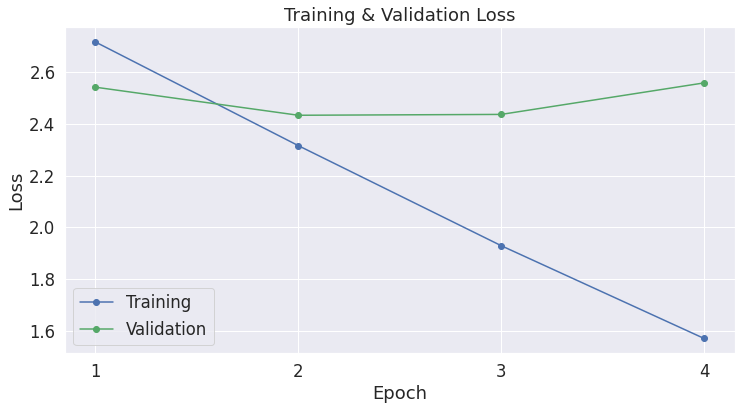

In [ ]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Generate Poems

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: From these we know that the good will be done,
The children be lifted up into the good will,
And the household wealth increase, and the works of the church
Shall prosper more or less."
He ended, and therewith a song most sweet
Rang through the ears of all the house,
And in the centre of the hall he heard,
An old man with a guitar in hand.


1: For you he has gone to the trap-room,
And snatched my kisses while I was a baby,
And led me into a sweet and silent measure
And told me what to do.  And then he came to say,
"I must go now, for I love you better than life,
You are a beautiful boy, and you are strong."
And she was not there--she only leaned her back,
And laughed and jogged my poor soul with her dolls,
Till, in some deep disgust, she turned her head and looked away.


2: Heigho! it's the Squire's Moon,
Fair as the berries of Northland,
On the islands are gleaming;
O why should we gaze upon those
Whose beauty has a far greater sway?
Why should we gaze upon those
Whose beauty is l

### Saving and Loading Finetuned Model

In [ ]:
output_dir = "/content/drive/My Drive/AutoCompose/models/joy2"

# Save generated poems
# sample_outputs = model.generate(
#                                 generated,
#                                 do_sample=True,
#                                 top_k=50,
#                                 max_length = 300,
#                                 top_p=0.95,
#                                 num_return_sequences=25
#                                 )

# with open(os.path.join(output_dir, 'generated_poems.txt'), "w") as outfile:
#   for i, sample_output in enumerate(sample_outputs):
#     outfile.write(tokenizer.decode(sample_output, skip_special_tokens=True)+"\n\n")

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(training_stats, os.path.join(output_dir, 'training_args.bin'))

('/content/drive/My Drive/AutoCompose/models/joy2/tokenizer_config.json',
 '/content/drive/My Drive/AutoCompose/models/joy2/special_tokens_map.json',
 '/content/drive/My Drive/AutoCompose/models/joy2/vocab.json',
 '/content/drive/My Drive/AutoCompose/models/joy2/merges.txt',
 '/content/drive/My Drive/AutoCompose/models/joy2/added_tokens.json')

In [ ]:
# Save generated poems
sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=25
                                )

with open(os.path.join(output_dir, 'generated_poems.txt'), "w") as outfile:
  for i, sample_output in enumerate(sample_outputs):
    outfile.write(tokenizer.decode(sample_output, skip_special_tokens=True)+"\n\n")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
# Loading saved model
model_dir = "/content/drive/My Drive/AutoCompose/models/neutral"

model = GPT2LMHeadModel.from_pretrained(model_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_dir)

# model = GPT2LMHeadModel.from_pretrained("prajwalcr/poetry-joy_gpt2")
# tokenizer = GPT2Tokenizer.from_pretrained("prajwalcr/poetry-joy_gpt2")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
